# Trabalho 2 - Python + MongoDB
-----
O objetivo deste trabalho é exercitar a utilização de banco de dados noSQL e manipulação de dados em Python. O dataset que será utilizado é o dataset de Comunicação de Acidentes do Trabalho, disponível no portal de dados aberto do Brasil: http://dados.gov.br
O dataset original completo é composto por 3 trimestres de comunicação de acidentes de trabalho (Jul-Set 2018, Out-Dez 2018 e Jan-Mar 2019). Cada dupla, em sua área Oracle, tem acesso a um recorte deste dataset, com até 29.000 instâncias, aproximadamente. Além disso, o dataset foi enriquecido com dados de populações das respectivas cidades dos correspondentes empregadores (não, não tem a cidade onde ocorreu o acidente de trabalho; somente o estado).

Abaixo, você encontra o passo a passo que deve ser seguido para realização do trabalho.


## 1 - Exportar os dados do Oracle
Você deve construir uma consulta que faça a junção entre os acidentes de trabalho disponíveis ao grupo e as populações dos municípios que aparecem no dataset, e exportar o resultados para `csv`. Ao exportar, definir delimitadores para não numéricos (", por exemplo) e a codificação adequada ('cp1252' é adequada).


## 2 - Ler o dataset e inserir no MongoDB

Você deve ler o dataset exportado no passo anterior, transformar os dados em formato de documento e fazer upload para a coleção do seu grupo no mongoDB. O nome da coleção é `dupla_x_collection`. O seu usário do MongoDB é `dupla_x`. A senha você deve ter recebido no moodle. Caso não saiba a sua senha de acesso, pergunte aos professores. **x** é o número da sua dupla! 

Para conectar no MongoDB a partir do python, você pode utilizar o código abaixo:

```python
from pymongo import MongoClient
user = 'dupla_x' # coloque o número da sua dupla aqui!
pwd = 'senhaDaSuaDupla' # coloque a senha da sua dupla aqui!
client = MongoClient('mongodb://{}:{}@ds151066.mlab.com:51066/datascience'.format(user, pwd))
db = client.datascience

# exemplo de consulta de documentos
cursor = db.dupla_x_collection.find() # x é o numero da sua dupla!!
```
O espaço alocado no MongoDB (MLAB), para cada grupo, é suficiente para a carga do `csv`. 


## 2 - Responder as seguintes perguntas utilizando consultas ao MongoDB

A dupla deve responder as seguintes perguntas, utilizando apenas consultas ao banco de dados.

1. Quais os 10 municípios com maior taxa de acidentes por 100 mil habitantes?
2. Quais as Naturezas das lesões, e correspondentes números de acidentes de trabalho, para naturezas de lesões cujo número de acidentes de trabalho é > 100?
3. Quais os agentes causadores de acidentes, e correspondentes números de acidentes, por mês-ano e para acidentes com óbitos, onde o número de óbitos por agente causador é > 2?

Dica: usem aggregate da API do MongoDB. Vejam mais informações em: 
https://docs.mongodb.com/manual/reference/method/db.collection.aggregate/
e
https://docs.mongodb.com/manual/reference/operator/aggregation-pipeline/


## 3 - Responder as seguintes perguntas utilizando Python (Pandas, Numpy e Matplotlib)

1. Quais os 10 municípios que mais possuem acidentes de trabalho? Faça um gráfico de barras para apresentar o resultado.
2. Quais os 10 municípios que mais possuem acidentes de trabalho por 100 mil habitantes? Faça um gráfico de barras para apresentar o resultado.
3. Qual a proporção de acidentes de trabalho em relação a cada estado? Faça um gráfico de pizza para mostrar o resultado.
4. Qual a natureza da lesão mais comum nos acidentes?
5. Qual é o comportamento do número de acidentes ao longo do tempo? Mostre a evolução do número de acientes utilizando um gráfico de linha.
 


## Entrega
A dupla deve entregar, **no moodle da disciplina de Banco de Dados Relacionais e Não Relacionais**, um **arquivo zip** com o seguinte nome: `dupla_x.zip`, onde **x** é o número da sua dupla. O arquivo `zip` deve conter os seguintes arquivos:
* Um relatório em `pdf` contendo a definição da visão definida no Oracle, e os resultados obtidos nas consultas sobre o MongoDB via MLAB.
* Este jupyter notebook contendo o código desenvolvido pela dupla.
* O dataset em `csv` exportado do Oracle.

<h3 style='color:red'>IMPORTANTE: A data de entrega do trabalho é 23/05.</h3>


## Critérios de avaliação

#### Critérios de avaliação da disciplina de Banco de Dados Relacionais e Não Relacionais
- Visão adequada para exportação, contendo a junção do recorte de dados de acidentes de trabalho e as populações dos municípios: 15%
- Arquivo `csv` exportado, com o conteúdo adequado: 10%
- Resolução das consultas propostas: 75% (25% para cada uma)


#### Critérios de avaliação da disciplina de Python Para Ciência de Dados
A nota deste trabalho equivale ao **Trabalho 2 (T2)** da disciplinina de de Python Para Ciência de Dados. A pontuação será calculada sobre as questões mostradas no **item 3**, cada questão vale **2 pontos** e será avaliada de acordo com os seguintes critérios:

- Resolver o problema proposto: 70%
- Utilizar código vetorizado: 20%
- Escrever código simples e legível: 10%

### O seu código deve ser escrito nas células abaixo. Crie novas células conforme a necesidade de abstração. Evite escrever o código inteiro em uma única célula.

In [127]:
# Imports e cargas iniciais
import numpy as np
import pandas as pd
import csv
import collections
import matplotlib.pyplot as plt
import sys
import time
import pprint
import json

from pymongo import MongoClient
from IPython.display import display as print_dataframe
from pprint import pprint
from pymongo.errors import BulkWriteError,WriteError
from unicodedata import normalize
from bson.son import SON

sys.getdefaultencoding()

'utf-8'

#### Conexão com a base

In [128]:
# Comece a escrever seu código aqui
from pymongo import MongoClient
user = 'dupla_11' # coloque o número da sua dupla aqui!
pwd = '8yyraqzb' # coloque a senha da sua dupla aqui!
client = MongoClient('mongodb://{}:{}@ds151066.mlab.com:51066/datascience'.format(user, pwd))
### Base alternativa - Descomentar a próxima linha e comentar a primeira
# client = MongoClient('mongodb+srv://{}:{}@cluster0-vdmfc.azure.mongodb.net/test?retryWrites=true'.format('equipe11', 'ChDcnlUCQ4w7lphV'))
db = client.datascience
acidentes = db["dupla_11_collection"]

#### Códigos de limpeza e reinserção de dados

In [129]:
### Limpeza

# Verificando se há conteúdo inicial
print("Encontrou",acidentes.count_documents({}),"registros antes da limpeza.")

#Realizando limpeza
result = acidentes.delete_many({})
print("Removidos",result.deleted_count,"registros.")

print(acidentes.count_documents({}),"registros após operação de limpeza." )

Encontrou 26248 registros antes da limpeza.
Removidos 26248 registros.
0 registros após operação de limpeza.


In [130]:
### Reinserção dos dados 
arquivo_csvpd = pd.read_csv('exportar.csv', header=0,encoding="cp1252")
tabela_dict = arquivo_csvpd.to_dict("records")

try:
    ## Inserção individual dos registros -- Lento e chega ao mesmo número máximo de registros
    #  for registro in tabeladict:
    #     acidentes.insert_one(registro)
    ## Inserção em massa de registros -- Mais rápido, mas apresentava quota exceeded
     acidentes.insert_many(tabela_dict,ordered=False)
    
    ## Tentativa de dividir em 4 partes e inserir com algum intervalo de tempo (5 min atualmente)
    ## Atualmente possui 26248 registros e insere no máximo 10914 registros
#     splits = np.array_split(tabeladict, 4)
# #     print(splits[1])
#     acidentes.insert_many(list(splits[1]))
# #     for piece in splits:
# #         acidentes.insert_many(list(piece))
#         time.sleep(300)
    
except BulkWriteError as bwe:
    print(bwe.details)
except WriteError as we:
    print(we.details)
   
print("Inseridos",acidentes.count_documents({}),"registros")

Inseridos 26248 registros


In [131]:
## Busca de um registro parar ver colunas e formato de dados para usar nas consultas
pprint(acidentes.find_one())

{'AGENTE_CAUSADOR_ACIDENTE': 'Balcao, Bancada - Mo',
 'CBO': 422110,
 'CID_10': 'S508',
 'CNAE20_EMPREGADOR': 8630.0,
 'DATA_ACIDENTE': '25/03/19',
 'DATA_EMISSAO_CAT': '28/03/19',
 'DATA_NASCIMENTO': '15/03/98',
 'EMITENTE_CAT': 'Empregador          ',
 'ESPECIE_DO_BENEFICIO': 'Pa                  ',
 'FILIACAO_SEGURADO': 'Empregado           ',
 'INDICA_OBITO_ACIDENTE': 'Não',
 'MES_ANO_ACIDENTE': '01/03/19',
 'MES_ANO_AFASTAMENTO': '01/03/19',
 'MES_ANO_DESPACHO_BENEFICIO': nan,
 'MUNIC_EMPREGADOR': 355030,
 'NATUREZA_DA_LESAO': 'Lesao Imediata      ',
 'NOME_MUNICÍPIO': 'São Paulo',
 'NOME_UF': 'São Paulo',
 'ORIGEM_DE_CADASTRAMENTO_CAT': 'Internet            ',
 'PARTE_CORPO_ATINGIDA': 'Braco (Entre O Punho',
 'POPULAÇÃO': 10886518,
 'SEXO': 'Feminino            ',
 'TIPO_DO_ACIDENTE': 'Típico              ',
 'UF_MUNIC_ACIDENTE': 'Maranhão            ',
 'UF_MUNIC_EMPREGADOR': 'São Paulo',
 '_id': ObjectId('5ce2236eeb45d9e31956d73d')}


## Inicio da resolução

## 2. Perguntas utilizando consultas ao MongoDB

A dupla deve responder as seguintes perguntas, utilizando apenas consultas ao banco de dados.

1. Quais os 10 municípios com maior taxa de acidentes por 100 mil habitantes?
2. Quais as Naturezas das lesões, e correspondentes números de acidentes de trabalho, para naturezas de lesões cujo número de acidentes de trabalho é > 100?
3. Quais os agentes causadores de acidentes, e correspondentes números de acidentes, por mês-ano e para acidentes com óbitos, onde o número de óbitos por agente causador é > 2?

Dica: usem aggregate da API do MongoDB. Vejam mais informações em: 
https://docs.mongodb.com/manual/reference/method/db.collection.aggregate/
e
https://docs.mongodb.com/manual/reference/operator/aggregation-pipeline/

In [133]:
# def converte_tipos(objeto):
#     return normalize('NFKD', objeto).encode('ASCII', 'ignore').decode('ASCII')

### 2.1. Quais os 10 municípios com maior taxa de acidentes por 100 mil habitantes?

pipeline = [
    {"$group":
         {
             "_id": "$NOME_MUNICÍPIO",
             "count": {"$sum": 1},
             "pop": { "$avg": "$POPULAÇÃO" }
         }
    },{"$addFields":
        {
            "acidentes_por_100mil": { "$divide": ["$count",  { "$divide": ["$pop", 100000] }] },
        }
    },{
        "$sort": {"acidentes_por_100mil": -1}
    }
 ]

print("2.1. Quais os 10 municípios com maior taxa de acidentes por 100 mil habitantes?")
pprint(list(acidentes.aggregate(pipeline))[:10])


## 2.2. Quais as Naturezas das lesões, e correspondentes números de acidentes de trabalho,
# para naturezas de lesões cujo número de acidentes de trabalho é > 100?
pipeline = [
    {"$group":
         {
             "_id": "$NATUREZA_DA_LESAO",
             "count": {"$sum": 1}
         } 
    },{
        "$match":  { "count": { "$gte": 100 } }
    },{
        "$sort": {"count": -1}
    }
 ]

print("\n2.2. Quais as Naturezas das lesões, e correspondentes números de acidentes de trabalho,para naturezas de lesões cujo número de acidentes de trabalho é > 100?")
pprint(list(acidentes.aggregate(pipeline)))


## 2.3. Quais os agentes causadores de acidentes, e correspondentes números de acidentes, por mês-ano e
# para acidente, mes_anos com óbitos, onde o número de óbitos por agente causador é > 2?
pipeline = [
    { "$match": {  "INDICA_OBITO_ACIDENTE": { "$eq": 'Sim' } } },
    { "$group": {
             "_id": {
                 "agente" : "$AGENTE_CAUSADOR_ACIDENTE",
                 "mes_ano" : "$MES_ANO_ACIDENTE"
             },
             "count": {"$sum": 1}
         } 
    },{
        "$match": {
             "count": { "$gte": 2 }
        }
    },{
        "$sort": {"count": -1}
    }
 ]

print("\n2.3. Quais os agentes causadores de acidentes, e correspondentes números de acidentes, por mês-ano e  para acidentemes_anos com óbitos, onde o número de óbitos por agente causador é > 2")
pprint(list(acidentes.aggregate(pipeline)))

2.1. Quais os 10 municípios com maior taxa de acidentes por 100 mil habitantes?
[{'_id': 'Borá',
  'acidentes_por_100mil': 1119.402985074627,
  'count': 9,
  'pop': 804.0},
 {'_id': 'Vista Alegre do Alto',
  'acidentes_por_100mil': 278.6885245901639,
  'count': 17,
  'pop': 6100.0},
 {'_id': 'Onda Verde',
  'acidentes_por_100mil': 267.6659528907923,
  'count': 10,
  'pop': 3736.0},
 {'_id': 'Cosmorama',
  'acidentes_por_100mil': 258.9555459646094,
  'count': 18,
  'pop': 6951.0},
 {'_id': 'Ipiguá',
  'acidentes_por_100mil': 254.77707006369425,
  'count': 10,
  'pop': 3925.0},
 {'_id': 'Mendonça',
  'acidentes_por_100mil': 226.13065326633165,
  'count': 9,
  'pop': 3980.0},
 {'_id': 'Rio das Pedras',
  'acidentes_por_100mil': 208.77619192225933,
  'count': 55,
  'pop': 26344.0},
 {'_id': 'Araçariguama',
  'acidentes_por_100mil': 203.40086241965665,
  'count': 25,
  'pop': 12291.0},
 {'_id': 'Nova Independência',
  'acidentes_por_100mil': 201.61290322580646,
  'count': 5,
  'pop': 2480.0

## 3 - Responder as seguintes perguntas utilizando Python (Pandas, Numpy e Matplotlib)

1. Quais os 10 municípios que mais possuem acidentes de trabalho? Faça um gráfico de barras para apresentar o resultado.
2. Quais os 10 municípios que mais possuem acidentes de trabalho por 100 mil habitantes? Faça um gráfico de barras para apresentar o resultado.
3. Qual a proporção de acidentes de trabalho em relação a cada estado? Faça um gráfico de pizza para mostrar o resultado.
4. Qual a natureza da lesão mais comum nos acidentes?
5. Qual é o comportamento do número de acidentes ao longo do tempo? Mostre a evolução do número de acientes utilizando um gráfico de linha.
 

In [134]:
## Carga dos dados para o dataframe
df = pd.DataFrame(acidentes.find({}))
print_dataframe(df)

,AGENTE_CAUSADOR_ACIDENTE,CBO,CID_10,CNAE20_EMPREGADOR,DATA_ACIDENTE,DATA_EMISSAO_CAT,DATA_NASCIMENTO,EMITENTE_CAT,ESPECIE_DO_BENEFICIO,FILIACAO_SEGURADO,...,NOME_MUNICÍPIO,NOME_UF,ORIGEM_DE_CADASTRAMENTO_CAT,PARTE_CORPO_ATINGIDA,POPULAÇÃO,SEXO,TIPO_DO_ACIDENTE,UF_MUNIC_ACIDENTE,UF_MUNIC_EMPREGADOR,_id
0,"Balcao, Bancada - Mo",422110,S508,8630.0,25/03/19,28/03/19,15/03/98,Empregador,Pa,Empregado,...,São Paulo,São Paulo,Internet,Braco (Entre O Punho,10886518,Feminino,Típico,Maranhão,São Paulo,5ce2236eeb45d9e31956d73d
1,"Motocicleta, Motonet",519110,S299,4689.0,28/03/19,28/03/19,29/12/87,Empregador,Pa,Empregado,...,Franca,São Paulo,Internet,"Membros Inferiores,",319094,Masculino,Trajeto,Maranhão,São Paulo,5ce2236eeb45d9e31956d73e
2,Chao - Superficie Ut,253305,S430,6611.0,21/03/19,28/03/19,01/11/90,Empregador,Pa,Empregado,...,São Paulo,São Paulo,Internet,Ombro,10886518,Masculino,Trajeto,Maranhão,São Paulo,5ce2236eeb45d9e31956d73f
3,Superficie e Estrutu,239405,S80,8599.0,25/03/19,28/03/19,04/02/69,Empregador,Pa,Empregado,...,Bariri,São Paulo,Internet,Articulacao do Torno,30995,Feminino,Trajeto,Maranhão,São Paulo,5ce2236eeb45d9e31956d740
4,Chao - Superficie Ut,515210,S934,8610.0,22/03/19,25/03/19,02/05/84,Empregador,Pa,Empregado,...,São Paulo,São Paulo,Internet,Perna (Entre O Torno,10886518,Feminino,Trajeto,Maranhão,São Paulo,5ce2236eeb45d9e31956d741
5,"Forno, Estufa, Retor",784205,T300,2539.0,12/03/19,25/03/19,10/03/89,Empregador,Pa,Empregado,...,Diadema,São Paulo,Internet,"Perna (Do Tornozelo,",386779,Masculino,Típico,Maranhão,São Paulo,5ce2236eeb45d9e31956d742
6,Veiculo Rodoviario M,783110,T302,4922.0,24/03/19,25/03/19,06/07/92,Empregador,Pa,Empregado,...,Campinas,São Paulo,Internet,"Membros Inferiores,",1039297,Masculino,Típico,Maranhão,São Paulo,5ce2236eeb45d9e31956d743
7,Chao - Superficie Ut,331110,M545,8411.0,21/03/19,22/03/19,29/07/63,Empregador,Pa,Empregado,...,Suzano,São Paulo,Internet,"Tronco, Nic",268777,Feminino,Trajeto,Maranhão,São Paulo,5ce2236eeb45d9e31956d71e
8,Veiculo Rodoviario M,521110,T07,5611.0,01/03/19,01/03/19,17/05/89,Empregador,Pa,Empregado,...,Itararé,São Paulo,Internet,Partes Multiplas - A,48732,Masculino,Típico,Maranhão,São Paulo,5ce2236eeb45d9e31956d71f
9,Piso de Edificio - S,517410,S934,8111.0,23/03/19,25/03/19,13/11/72,Empregador,Pa,Empregado,...,Jundiaí,São Paulo,Internet,Articulacao do Torno,342983,Masculino,Típico,Maranhão,São Paulo,5ce2236eeb45d9e31956d720


 3.1. Quais os 10 municípios que mais possuem acidentes de trabalho? Faça um gráfico de barras para apresentar o resultado
NOME_MUNICÍPIO
São Paulo                7245
Guarulhos                 799
Campinas                  724
São Bernardo do Campo     551
Ribeirão Preto            545
São José do Rio Preto     545
Santo André               505
Jundiaí                   479
Piracicaba                452
Barueri                   431
Name: _id, dtype: int64


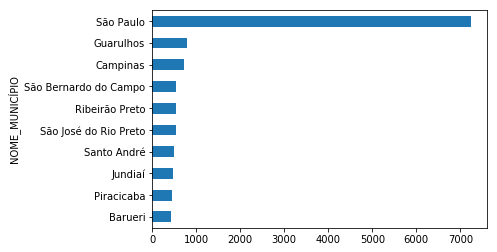

In [135]:
## 3.1. Quais os 10 municípios que mais possuem acidentes de trabalho? Faça um gráfico de barras para apresentar o resultado

gp=df.groupby(by='NOME_MUNICÍPIO')

print(' 3.1. Quais os 10 municípios que mais possuem acidentes de trabalho? Faça um gráfico de barras para apresentar o resultado')
cidades_sorted=gp['_id'].count().sort_values(ascending=False)[:10]
pprint(cidades_sorted)
cidades_sorted.plot.barh().invert_yaxis()


 3.2. Quais os 10 municípios que mais possuem acidentes de trabalho por 100 mil habitantes? Faça um gráfico de barras para apresentar o resultado.


NOME_MUNICÍPIO
Borá                    1119.402985
Vista Alegre do Alto     278.688525
Onda Verde               267.665953
Cosmorama                258.955546
Ipiguá                   254.777070
Mendonça                 226.130653
Rio das Pedras           208.776192
Araçariguama             203.400862
Nova Independência       201.612903
Pontes Gestal            201.045436
dtype: float64

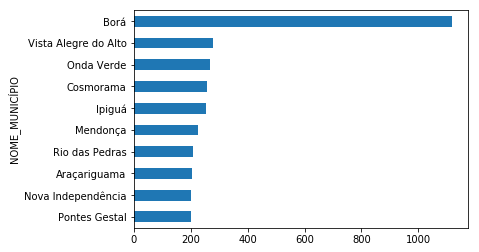

In [136]:
## 3.2. Quais os 10 municípios que mais possuem acidentes de trabalho por 100 mil habitantes? Faça um gráfico de barras para apresentar o resultado.
cidades100k = (gp['_id'].count()/(gp['POPULAÇÃO'].mean()/100000)).sort_values(ascending=False)[:10]

print(' 3.2. Quais os 10 municípios que mais possuem acidentes de trabalho por 100 mil habitantes? Faça um gráfico de barras para apresentar o resultado.')
print_dataframe(cidades100k)
cidades100k.plot.barh().invert_yaxis()

3.3. Qual a proporção de acidentes de trabalho em relação a cada estado? Faça um gráfico de pizza para mostrar o resultado.


UF_MUNIC_ACIDENTE
Maranhão      25654
Tocantins       146
Rondônia        116
                 73
{ñ class}        52
Roraima          50
Pará             26
Ceará            24
Acre             12
Alagoas           9
Amapá             7
Pernambuco        6
Piauí             4
Sergipe           3
Amazonas          3
Paraíba           1
Name: _id, dtype: int64

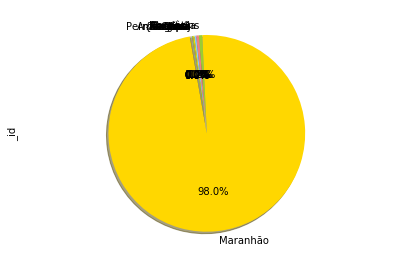

In [137]:
## 3.3. Qual a proporção de acidentes de trabalho em relação a cada estado? Faça um gráfico de pizza para mostrar o resultado.
## Exibindo 'UF_MUNIC_ACIDENTE' para exibir algo diferente de São Paulo
## Arrumando valores da coluna UF_MUNIC_ACIDENTE
df['UF_MUNIC_ACIDENTE'] = df['UF_MUNIC_ACIDENTE'].str.strip()

print("3.3. Qual a proporção de acidentes de trabalho em relação a cada estado? Faça um gráfico de pizza para mostrar o resultado.")

gpuf=df.groupby(by='UF_MUNIC_ACIDENTE')
acidentes_uf=gpuf['_id'].count().sort_values(ascending=False)
print_dataframe(acidentes_uf)



colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
plt.axis('equal')
plt.tight_layout()
acidentes_uf.plot.pie(   colors=colors,autopct='%1.1f%%', shadow=True, startangle=100)

In [155]:
# 3.4. Qual a natureza da lesão mais comum nos acidentes?
gpnl=df.groupby(by='NATUREZA_DA_LESAO')

print("3.4. Qual a natureza da lesão mais comum nos acidentes?")
print(gpnl['_id'].count().sort_values(ascending=False)[:1])



3.4. Qual a natureza da lesão mais comum nos acidentes?
NATUREZA_DA_LESAO
Corte, Laceracao, Fe    5518
Name: _id, dtype: int64


In [ ]:
## 3.5. Qual é o comportamento do número de acidentes ao longo do tempo? 
## Mostre a evolução do número de acientes utilizando um gráfico de linha.